# Creating note alignments from sequential alignment information

Dynamic Time Warping and related sequence alignment algorithms return a path between two sequences or time series. Note alignment of two polyphonic parts is categorically different from a time series alignment. To get to a note alignment, we need to figure out what notes are played at a specific time in the piano roll. Sometimes this information might be imprecise so we need to relax the search for notes at some piano roll time to find all relevant notes.

In [1]:
import os
# Uncomment this line if the kernel keeps crashing
# See https://stackoverflow.com/a/53014308
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from typing import List

import partitura as pt

import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format ='retina'

In [2]:
path_to_musicxml = os.path.join("..","introduction","example_data","Chopin_op10_no3.musicxml")
part = pt.load_musicxml(path_to_musicxml)

C:\Users\Ripple\AppData\Local\Programs\Python\Python39\lib\site-packages\partitura\directions.py:533: UserWarning: error parsing "ritenuto" (UnexpectedCharacters)
  warnings.warn('error parsing "{}" ({})'.format(string, type(e).__name__))


In [3]:
piano_roll, idx = pt.utils.music.compute_pianoroll(part, return_idxs = True)

In [4]:
# pitch, onset, offset
idx

array([[ 59,   0,   4],
       [ 40,   4,  12],
       [ 40,   4,   6],
       ...,
       [ 64, 324, 332],
       [ 66, 324, 325],
       [ 68, 324, 325]])

In [5]:
# idx correspond to notes in note_array
part.note_array

<bound method Score.note_array of <partitura.score.Score object at 0x00000221F8C3BF40>>

In [6]:
# let's import a MIDI file for testing
path_to_midi = os.path.join("..","introduction","example_data","Chopin_op10_no3_p01.mid")
ppart = pt.load_performance_midi(path_to_midi)
ppiano_roll, pidx = pt.utils.music.compute_pianoroll(ppart, return_idxs = True)

C:\Users\Ripple\AppData\Local\Programs\Python\Python39\lib\site-packages\partitura\io\importmidi.py:140: UserWarning: change of Tempo to mpq = 500000  and resulting seconds per tick = 0.000125at time: 0.0
  warnings.warn(
C:\Users\Ripple\AppData\Local\Programs\Python\Python39\lib\site-packages\partitura\utils\music.py:1046: UserWarning: Do not consider drum track for computing piano roll
  warnings.warn("Do not consider drum track for computing piano roll")


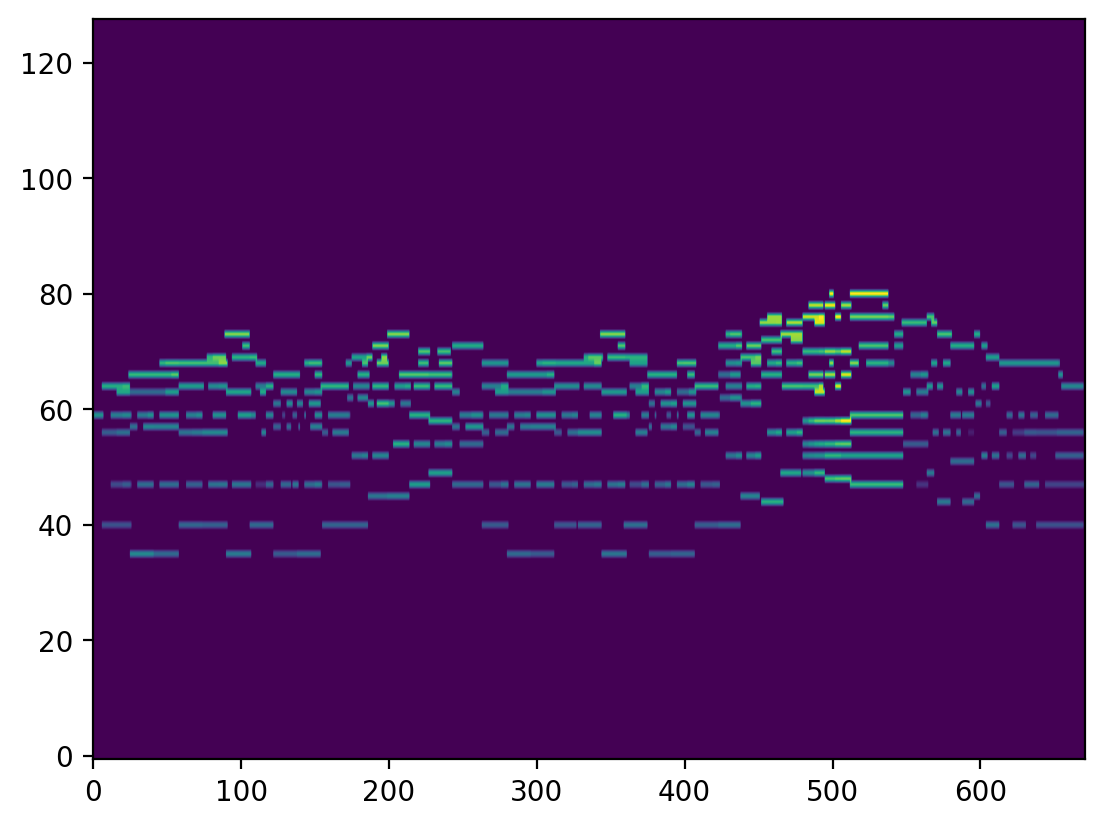

In [7]:
%matplotlib inline
plt.imshow(ppiano_roll.todense(), aspect = "auto", origin="lower")

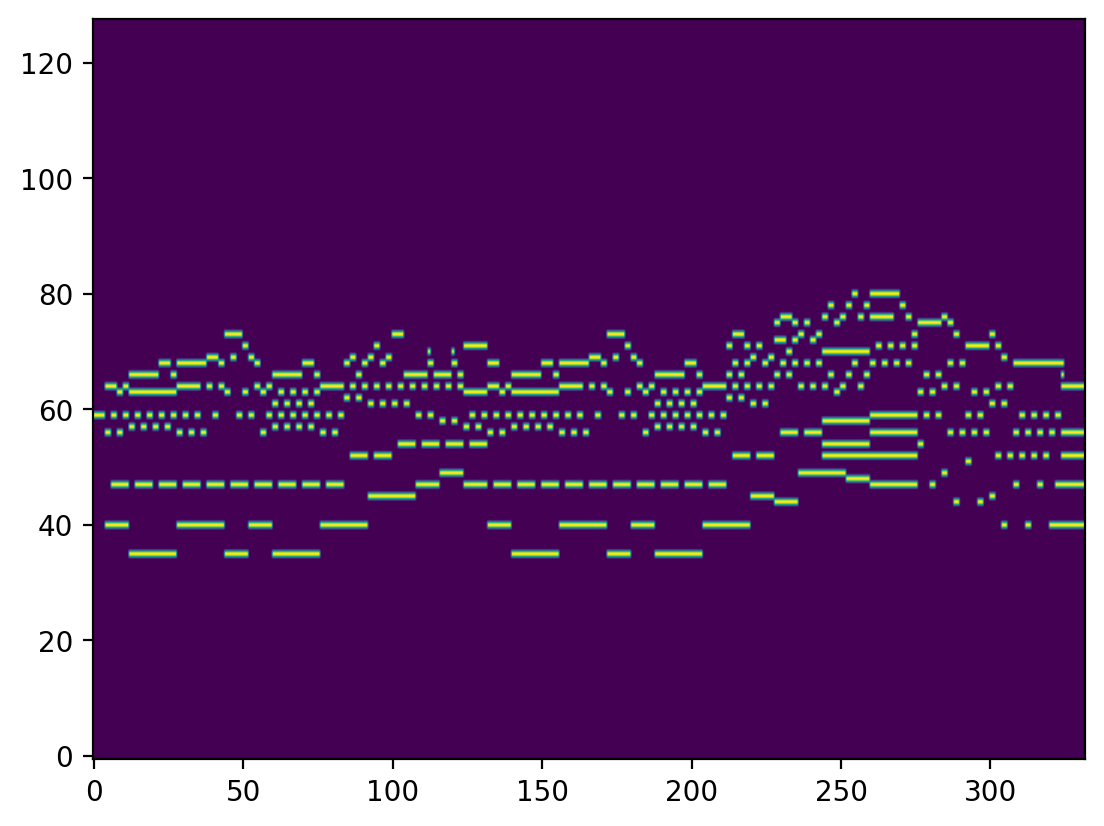

In [8]:
plt.imshow(piano_roll.todense(), aspect = "auto", origin="lower")

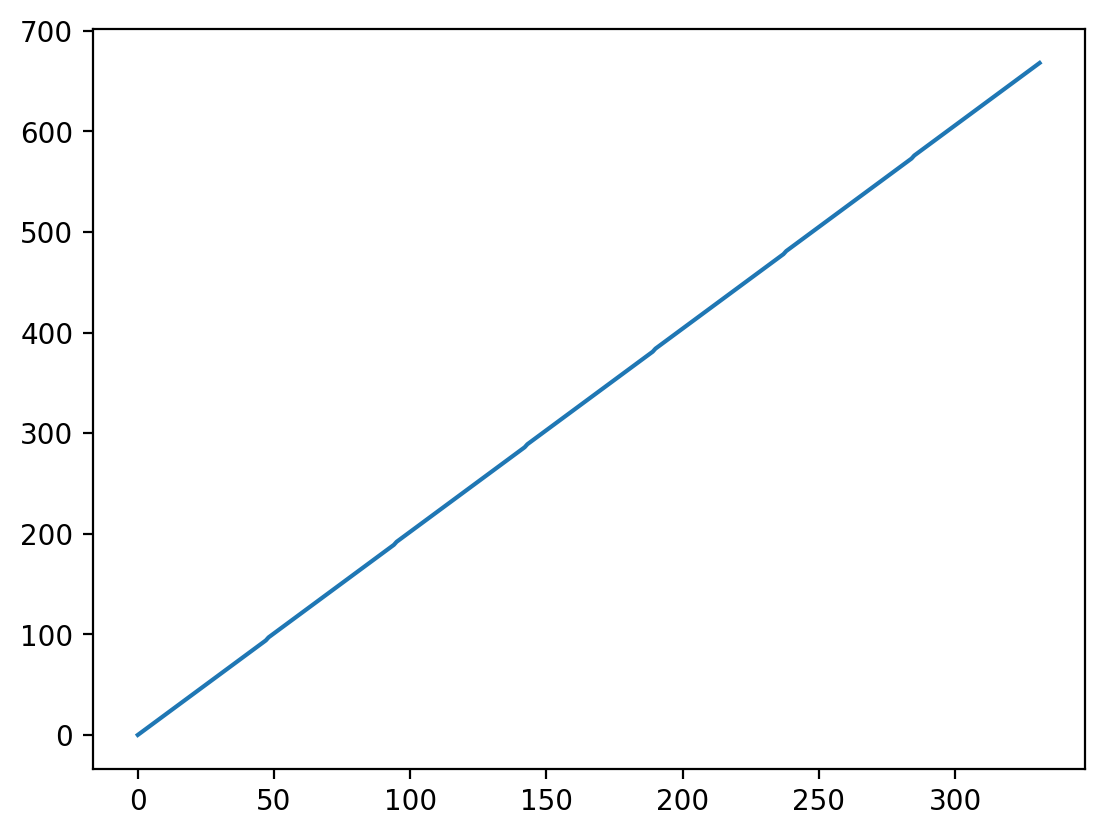

In [9]:
# invent a linear alignment for testing

alignment_times_xml = np.arange(piano_roll.todense().shape[1])
alignment_times_mid = np.floor(np.arange(piano_roll.todense().shape[1])*ppiano_roll.todense().shape[1]/piano_roll.todense().shape[1])

linear_alignment = np.column_stack([alignment_times_xml, alignment_times_mid]).astype(int)
plt.plot(alignment_times_xml,alignment_times_mid)

In [10]:
linear_alignment

array([[  0,   0],
       [  1,   2],
       [  2,   4],
       [  3,   6],
       [  4,   8],
       [  5,  10],
       [  6,  12],
       [  7,  14],
       [  8,  16],
       [  9,  18],
       [ 10,  20],
       [ 11,  22],
       [ 12,  24],
       [ 13,  26],
       [ 14,  28],
       [ 15,  30],
       [ 16,  32],
       [ 17,  34],
       [ 18,  36],
       [ 19,  38],
       [ 20,  40],
       [ 21,  42],
       [ 22,  44],
       [ 23,  46],
       [ 24,  48],
       [ 25,  50],
       [ 26,  52],
       [ 27,  54],
       [ 28,  56],
       [ 29,  58],
       [ 30,  60],
       [ 31,  62],
       [ 32,  64],
       [ 33,  66],
       [ 34,  68],
       [ 35,  70],
       [ 36,  72],
       [ 37,  74],
       [ 38,  76],
       [ 39,  78],
       [ 40,  80],
       [ 41,  82],
       [ 42,  84],
       [ 43,  86],
       [ 44,  88],
       [ 45,  90],
       [ 46,  92],
       [ 47,  94],
       [ 48,  97],
       [ 49,  99],
       [ 50, 101],
       [ 51, 103],
       [ 52,

In [11]:
def greedy_note_alignment(
    warping_path: np.ndarray,
    idx1: np.ndarray,
    note_array1: np.ndarray,
    idx2: np.ndarray,
    note_array2: np.ndarray,
) -> List[dict]:
    """
    Greedily find and store possible note alignments

    Parameters
    ----------
    warping_path : numpy ndarray
        alignment sequence idx in stacked columns
    idx1: numpy ndarray
        pitch, start, and end coordinates of all notes in note_array1
    note_array1: numpy structured array
        note_array of sequence 1 (the score)
    idx2: numpy ndarray
        pitch, start, and end coordinates of all notes in note_array2
    note_array2: numpy structured array
        note_array of sequence 2 (the performance)

    Returns
    ----------
    note_alignment : list
        list of note alignment dictionaries

    """
    note_alignment = []
    used_notes1 = list()
    used_notes2 = list()

    # loop over all notes in sequence 1
    for note1, coord1 in zip(note_array1, idx1):
        note1_id = note1["id"]
        pitch1, s1, e1 = coord1

        # find the coordinates of the note in the warping_path

        idx_in_warping_path = np.all(
            [warping_path[:, 0] >= s1, warping_path[:, 0] <= e1], axis=0
        )
        # print(idx_in_warping_path, idx_in_warping_path.shape)
        range_in_sequence2 = warping_path[idx_in_warping_path, 1]
        max2 = np.max(range_in_sequence2)
        min2 = np.min(range_in_sequence2)

        # loop over all notes in sequence 2 and pick the notes with same pitch
        # and position
        for note2, coord2 in zip(note_array2, idx2):
            note2_id = note2["id"]
            pitch2, s2, e2 = coord2
            if note2_id not in used_notes2:
                if pitch2 == pitch1 and s2 <= max2 and e2 >= min2:

                    note_alignment.append(
                        {
                            "label": "match",
                            "score_id": note1_id,
                            "performance_id": str(note2_id),
                        }
                    )
                    used_notes2.append(str(note2_id))
                    used_notes1.append(note1_id)

        # check if a note has been found for the sequence 1 note,
        # otherwise add it as deletion
        if note1_id not in used_notes1:
            note_alignment.append({"label": "deletion", "score_id": note1_id})
            used_notes1.append(note1_id)

    # check again for all notes in sequence 2, if not used,
    # add them as insertions
    for note2 in note_array2:
        note2_id = note2["id"]
        if note2_id not in used_notes2:
            note_alignment.append(
                {
                    "label": "insertion",
                    "performance_id": str(note2_id),
                }
            )
            used_notes2.append(str(note2_id))

    return note_alignment


In [12]:
note_alignment  = greedy_note_alignment(linear_alignment, idx, part.note_array(), pidx, ppart.note_array())

In [13]:
note_alignment

[{'label': 'match', 'score_id': 'n1', 'performance_id': 'n0'},
 {'label': 'match', 'score_id': 'n4', 'performance_id': 'n1'},
 {'label': 'deletion', 'score_id': 'n4voice_overlap'},
 {'label': 'match', 'score_id': 'n3', 'performance_id': 'n3'},
 {'label': 'match', 'score_id': 'n2', 'performance_id': 'n2'},
 {'label': 'match', 'score_id': 'n6', 'performance_id': 'n4'},
 {'label': 'match', 'score_id': 'n6', 'performance_id': 'n10'},
 {'label': 'match', 'score_id': 'n5', 'performance_id': 'n5'},
 {'label': 'match', 'score_id': 'n8', 'performance_id': 'n7'},
 {'label': 'match', 'score_id': 'n7', 'performance_id': 'n6'},
 {'label': 'deletion', 'score_id': 'n11'},
 {'label': 'match', 'score_id': 'n10', 'performance_id': 'n9'},
 {'label': 'match', 'score_id': 'n9', 'performance_id': 'n8'},
 {'label': 'match', 'score_id': 'n15', 'performance_id': 'n12'},
 {'label': 'deletion', 'score_id': 'n15voice_overlap'},
 {'label': 'match', 'score_id': 'n14', 'performance_id': 'n14'},
 {'label': 'match', '

To inspect an alignment, we can use [**Parangonada**](https://sildater.github.io/parangonada/), a tool to compare alignments developed at our institute!

In [1]:
# Export files to Parangonada
outdir = "parangonada_files"
if not os.path.exists(outdir):
    os.mkdir(outdir)
pt.save_parangonada_csv(
    alignment=note_alignment,
    performance_data=ppart,
    score_data=part,
    outdir="parangonada_files",
)


NameError: name 'os' is not defined